# Summing two binomial distributions

In [1]:
from scipy.stats import binom

import pymc3 as pm
import pandas as pd
import numpy as np

In [2]:
np.random.seed(42)

## Background question

Given a job vacancy with multiple candidates requested, what is the chance `n_requested` gets fulfilled?

What we know:
* Candidates that have an interview scheduled (`n_interviews`) have a certain chance of getting hired (`p_interviews`)
* Candidates that have applied for the job (`n_applications`) have a certain chance of getting hired (`p_applications`)

The chances of getting hired (true or false) for both interview and application candidates comes from historical data and can best be modelled as a binomial distribution with parameters `n` and `p`.

### The problem

If `n_interviews < n_requested` and `n_applications < n_requested` there is no chance the vacancy is going to be completely fulfilled with candidates from one pool only. This means we have to look into combinations of both interview and applications candidates to fulfill the vacancy.

Consider the following example case:

In [3]:
n_requested = 3
n_applications = 2
p_applications = 0.1
n_interviews = 2
p_interviews = 0.3

## Binomial distribution

First, let's understand the binomial distribution and how we can model the chance of a request being fulfilled by just a single type of candidates first. When we understand this, we can increase the example from one to two binomial distributions.

A binomial distribution can be created using `scipy.stats.binom`:

In [4]:
binom_app = binom(n_applications, p_applications)

The **probability mass function (PMF)** is then a function that gives the probability that a discrete random variable is exactly equal to some value. 

So printing the odds that exactly `k` people get hired:

In [5]:
for k in range (n_requested + 1):
    print(k, binom_app.pmf(k))

0 0.8099999999999999
1 0.18000000000000005
2 0.010000000000000004
3 0.0


In other words: there's 18% chance one applicant gets hired. And 0% that 3 applicants get hired (this is also not possible as only 2 candidates are applying).

The **cumulative distribution function (CDF)** will print the probability that X will take a value less than or equal to some number. This considers all possible combinations that are possible. 

More usefull in our case is to look at it's complement, which gives us the probability that `more than k` applicants get hired:

In [6]:
for k in range (n_requested + 1):
    print(k, 1 - binom_app.cdf(k))

0 0.18999999999999995
1 0.010000000000000009
2 0.0
3 0.0


So there's a 19% chance 1 or 2 applicants get hired and a 1% chance 2 applicants get hired.

We can make this a generic function, that calculates the chance of a specific `n_request` being fulfilled by some binomial distributions with parameters `n_population` and `p_hired`:

In [7]:
def p_request_fulfilled(n_requested, n_population, p_hired):
    "Calculate chance of request being fulfilled depending on population size and the chance of getting hired"
    binom_dist = binom(n_population, p_hired)
    return 1 - binom_dist.cdf(n_requested - 1)

print('Chance of request being fulfilled:', 
      p_request_fulfilled(1, 2, 0.1))

Chance of request being fulfilled: 0.18999999999999995


In [8]:
print('Chance of request being fulfilled:', 
      p_request_fulfilled(2, 2, 0.1))

Chance of request being fulfilled: 0.010000000000000009


In [9]:
print('Chance of request being fulfilled:', 
      p_request_fulfilled(1, 1, 0.1))

Chance of request being fulfilled: 0.09999999999999998


These outcomes make sense.

## Summing two binomial distributions?

As state earlier, the problem is that both distributions indicate that there is 0 chance of fulfilling the `n_requested` of 3 on their own. We thus have to look at their distributions together and investigate the area of overlap.

### Manual calculation for ground truth

There are 3 ways in which we can fullfill the demand of `n_requested = 3`:

* 2 succesfull applicants + 1 succesfull interviewiee
* 1 succesfull applicant  + 2 succesfull interviewiees
* 2 succesfull applicants + 2 succesfull interviewiees

Let's calculate what the output chance should be using **PMF** to calculate the above exact possibilities:

In [10]:
binom_app = binom(n_applications, p_applications)
binom_int = binom(n_interviews, p_interviews)

# Calculate true chance of 3 requests to be fulfilled from two binomial distributions
truth = binom_app.pmf(2) * binom_int.pmf(1) + \
        binom_app.pmf(1) * binom_int.pmf(2) + \
        binom_app.pmf(2) * binom_int.pmf(2)

print('True chance:', truth)

True chance: 0.021300000000000003


So this is what our final function should output for this specific case.

### Theory

What is the distribution of the variable 𝑋 given: 

𝑋=𝑌+𝑍,

where 𝑌∼ Binomial(𝑛, 𝑃𝑌) and 𝑍∼ Binomial(𝑛, 𝑃𝑍)?

According to [wikipedia](https://en.wikipedia.org/wiki/Binomial_sum_variance_inequality):

> the sum of independent binomial random variables is itself a binomial random variable if all the component variables share the same success probability. If success probabilities differ, the probability distribution of the sum is not binomial.

As in our case 𝑃𝑌 != 𝑃𝑍, this means we know that 𝑌 will **not** be binomial itself.. meaning theory doesn't help us.


### Practice

An option would be to use a more "brute force" kind of strategy, wherein we consider both distributions and use the probability mass function to sum all the probabilities where `i_applications + j_interviews > n_requested`:

In [11]:
def p_request_fulfilled_two_binomials(n_requested, n1, n2, p1, p2):
    """Calculated the chance of a requested being fulfilled by considering all 
       combinations from two binomial distributions"""
    all_probs = 0
    binom1 = binom(n1, p1)
    binom2 = binom(n2, p2)
    
    # loop over the number of candidates in application
    for i in range(n1 + 1):
        # loop over the number of candidates scheduled for interview
        for j in range(n2 + 1):
            # consider if the cases fulfills the number of candidates requested 
            if i + j >= n_requested:
                # calculate the chance of that scenario happening and add it to the total
                all_probs += binom1.pmf(i) * binom2.pmf(j)
    return all_probs
            
print('Chance of request being fulfilled:',
      p_request_fulfilled_two_binomials(n_requested, n_applications, n_interviews, p_applications, p_interviews))

Chance of request being fulfilled: 0.021300000000000003


Looks good, as that matches with the `truth` that we expected. 

Let's try with another scenario:

In [12]:
n_requested = 10
n_applications = 8
p_applications = 0.5
n_interviews = 8
p_interviews = 0.5

print('Chance of request being fulfilled:',
      p_request_fulfilled_two_binomials(n_requested, n_applications, n_interviews, p_applications, p_interviews))

Chance of request being fulfilled: 0.2272491455078127


Still makes sense. Now what if the request should be easily fulfilled?

In [13]:
n_requested = 1
n_applications = 8
p_applications = 0.1
n_interviews = 8
p_interviews = 0.3

print('Chance of request being fulfilled:',
      p_request_fulfilled_two_binomials(n_requested, n_applications, n_interviews, p_applications, p_interviews))

Chance of request being fulfilled: 0.9751844219732483


Great! 

But... does it scale? What if `n_applications` and `n_interviews` is way bigger than `n_requested`?

In [14]:
%%time

n_requested = 60
n_applications = 300
p_applications = 0.1
n_interviews = 100
p_interviews = 0.3

print('Chance of request being fulfilled:',
      p_request_fulfilled_two_binomials(n_requested, n_applications, n_interviews, p_applications, p_interviews))

Chance of request being fulfilled: 0.5227896252432689
CPU times: user 4.88 s, sys: 78.5 ms, total: 4.96 s
Wall time: 4.92 s


It's not super fast, but what are the odds for this scenario? Also, likely an overnight batch job for this solution should be fine. 

If wanted, speed up by vectorizing/parallellizing the solution:

In [15]:
%%timeit

# just timing, no printing
p_request_fulfilled_two_binomials(n_requested, n_applications, n_interviews, p_applications, p_interviews)

4.35 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

# just timing, no printing. Vectorized solution
bino_app = binom(n_applications, p_applications)
bino_int = binom(n_interviews, p_interviews)
probs_app = [bino_app.pmf(i) for i in range(n_requested)]
probs_int = [bino_int.pmf(i) for i in range(n_requested)]

# calculate probabilities of all possible combinations, then sum the ones that we need
all_probs = np.outer(probs_app, probs_int)
mask = (np.arange(n_requested).reshape(-1, 1) + np.arange(n_requested).reshape(1, -1)) < n_requested
final = all_probs[mask].sum()

# print(1 - final)

11.1 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Indeed a vectorized version is way faster.

## Alternative solution: `pymc3`!

The above calculations don't give you any uncertainty estimate. Also, it assumes that the `p_applications` and `p_interviews` are deterministic, even though these are also just sample averages that carry uncertainty themselves. 

Can we do something about this with sampling methods? Yes! We can model the chances based on the `n` and `hits` they were actually calculated with. We can then propagate this into the Binomial distributions and create a deterministic `total_selected` that sums both samples from the Binomial distributions:

![model of problem](../figures/summing-binomial-distributions-pymc3.jpeg)

Let's run it once with `p_applications` and `p_interviews` based on a large numbers of `totals` and `hits`:

In [17]:
%%time 

n_applications = 2
applications_total = 10000
applications_hits = 1000 # -> 10%

n_interviews = 2
interviews_total = 300
interviews_hits = 100 # -> 30%

with pm.Model() as model:
    # set priors for p_applications and p_interviews
    prior_interviews = pm.Beta("prior_interviews", interviews_hits, interviews_total) # 30%
    prior_applications = pm.Beta("prior_applications", applications_hits, applications_total) # 10% 
    # model binomial distributions with n_applications and n_interviews
    num_interviews = pm.Binomial("num_good", n_interviews, prior_interviews)
    num_applications = pm.Binomial("num_bad", n_applications, prior_applications)
    # define total as sum of both and start sampling
    total_selected = pm.Deterministic("total", num_interviews + num_applications)
    trace = pm.sample(5000, model=model, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [num_bad]
>Metropolis: [num_good]
>Metropolis: [prior_applications]
>Metropolis: [prior_interviews]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:04<00:00, 5382.81draws/s]
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 6.09 s, sys: 607 ms, total: 6.69 s
Wall time: 9.01 s


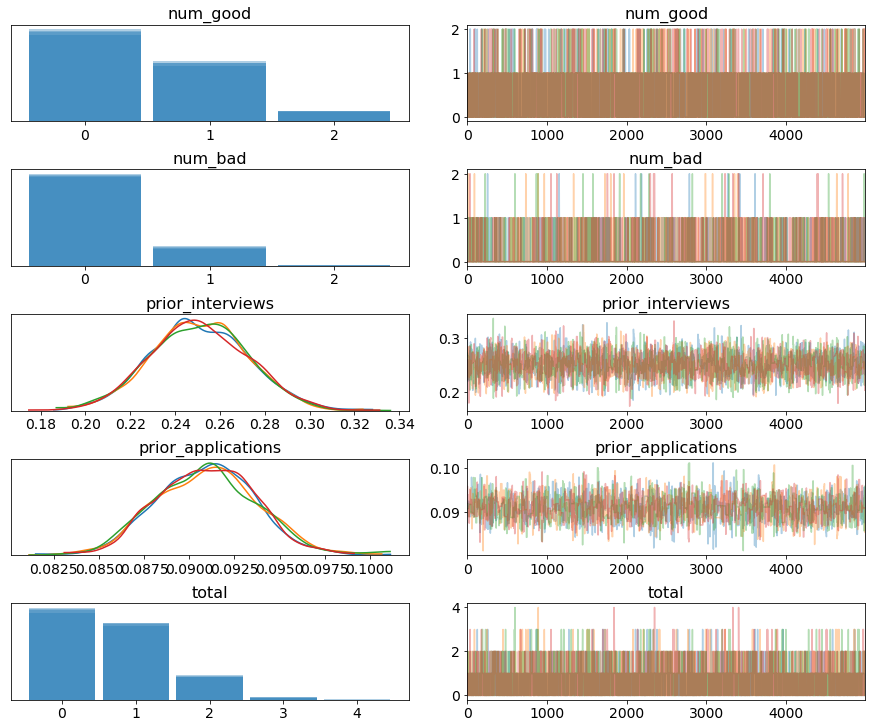

In [18]:
pm.traceplot(trace);

We can extract the occurances for each of the totals to get a sense of their likelihood:

In [19]:
df = pm.trace_to_dataframe(trace)

(
    df
    .groupby('total')
    .apply(lambda x: pd.Series({
        'count': len(x),
        'percentage' : len(x)/len(df) * 100
    }))
)

,count,percentage
total,,
0,9365.0,46.825
1,7918.0,39.590
2,2454.0,12.270
3,251.0,1.255
4,12.0,0.060


It seems there is very little likelihood of the event `total_selected >= 3`, it's less than the 2.13% we saw with the Binomial distribution. How come?

In [20]:
print('Chance of request being fulfilled:',
      len(df.loc[df['total'] >= 3]) / len(df))

Chance of request being fulfilled: 0.01315


Now what happens to our estimate if we are basing our priors of `p_applications` and `p_interviews` on a smaller numbers of `totals` and `hits`? At least we would expect more uncertainty in both priors.

In [21]:
%%time 
import pymc3 as pm

n_applications = 2
applications_total = 10
applications_hits = 1 # -> 10%

n_interviews = 2
interviews_total = 3
interviews_hits = 1 # -> 30%

with pm.Model() as model:
    # set priors for p_applications and p_interviews
    prior_interviews = pm.Beta("prior_interviews", interviews_hits, interviews_total) # 30%
    prior_applications = pm.Beta("prior_applications", applications_hits, applications_total) # 10% 
    # model binomial distributions with n_applications and n_interviews
    num_interviews = pm.Binomial("num_good", n_interviews, prior_interviews)
    num_applications = pm.Binomial("num_bad", n_applications, prior_applications)
    # define total as sum of both and start sampling
    total_selected = pm.Deterministic("total", num_interviews + num_applications)
    trace = pm.sample(5000, model=model, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [num_bad]
>Metropolis: [num_good]
>Metropolis: [prior_applications]
>Metropolis: [prior_interviews]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:03<00:00, 5626.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


CPU times: user 5.69 s, sys: 346 ms, total: 6.04 s
Wall time: 6.72 s


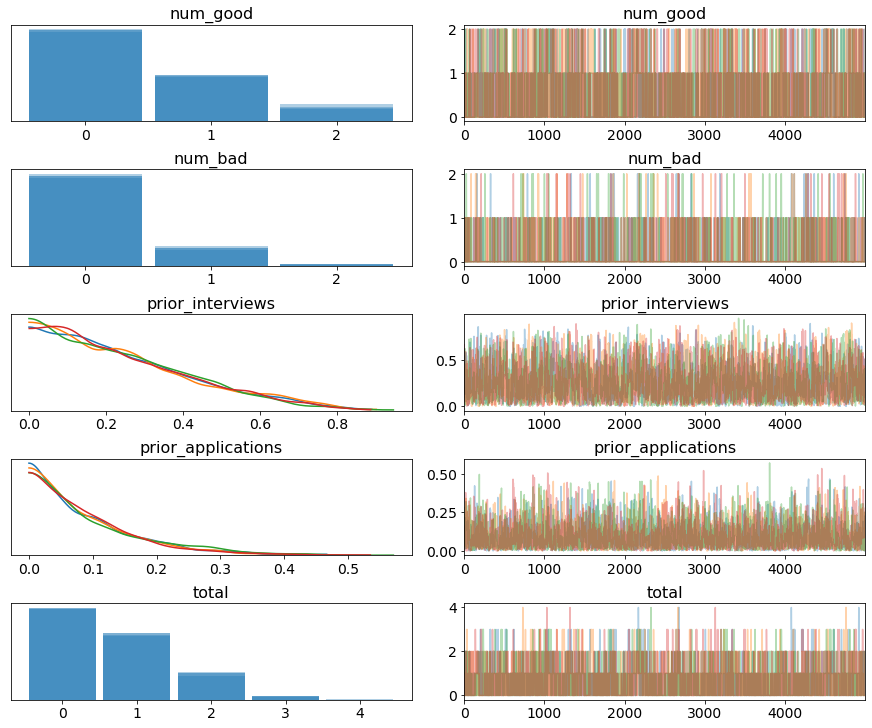

In [22]:
pm.traceplot(trace);

Indeed the priors look very odd, and we seem that both our priors have a way longer right-sided tail then the previous case where we were more certain of our `p_applications` and `p_interviews`!

What does this mean for our estimate of getting at least 3 job candidates (`total_selected >= 3`)?

In [23]:
df = pm.trace_to_dataframe(trace)

(
    df
    .groupby('total')
    .apply(lambda x: pd.Series({
        'count': len(x),
        'percentage' : len(x)/len(df) * 100
    }))
)

,count,percentage
total,,
0,9764.0,48.820
1,6990.0,34.950
2,2846.0,14.230
3,379.0,1.895
4,21.0,0.105


It's more! And actually, very close to the Binomial number that doesn't take the uncertainty into account:

In [24]:
print('Chance of request being fulfilled:',
      len(df.loc[df['total'] >= 3]) / len(df))

Chance of request being fulfilled: 0.02


A good example of how `pymc3` can help provide more insight in your accuracy.

### Next steps

Add an uncertainty margin around the chance of being fulfilled through bootstrapping? Bootstrapping is not possible for the brute force approach, but it is for `pymc3`. Run the experiment a couple of times and look into the variance of the number (although this could take a long time).

Done.